In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import StratifiedKFold

from CrabNet_spacegroup.kingcrab import CrabNet
from CrabNet_spacegroup.model import Model
from CrabNet_spacegroup.get_compute_device import get_compute_device

from sklearn.metrics import mean_absolute_error as mae, \
                            r2_score as r2, \
                            mean_squared_error as mse

compute_device = get_compute_device()

In [2]:
from pymatgen.core import Composition

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

config = {
    "mathtext.fontset":'stix',
    "font.family":'serif',
    "font.serif": ['Times New Roman'],
    "font.size": 24,
    'axes.unicode_minus': False 
}
rcParams.update(config)
plt.rcParams['axes.unicode_minus'] = False  
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 6),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 300 

In [3]:
df = pd.read_csv('./data/data.csv', index_col=0)
df['is_metal'] = df['target'].map(lambda x: 1 if x==0 else 0)
df['is_metal'].value_counts()

0    70216
1    64037
Name: is_metal, dtype: int64

In [4]:
df['index'] = df.index
spinels = pd.read_csv('./data/spinel_oxides.csv')
spinels = spinels[['formula_pretty','spacegroup_number','band_gap','is_gap_direct']]
spinels.columns = ['formula','spacegroup','GGA','is_gap_direct']
spinels['index'] = spinels.index
spinels = pd.merge(spinels,df , on=['formula','spacegroup'], how='inner')

In [5]:
df = df.drop(index=spinels['index_y'])
df = df.reset_index(drop=True)
spinels = spinels[['formula','spacegroup','GGA_x','target','is_gap_direct']]
spinels.columns = ['formula','spacegroup','GGA','target','is_gap_direct']

In [6]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_indices = kf.split(df["formula"], df["is_metal"])
for i, (train_index, val_index) in enumerate(cv_indices):
    train, val = df.loc[train_index], df.loc[val_index]
    name = f"fold_{i}"
    model = Model(CrabNet(compute_device=compute_device).to(compute_device),
                      model_name=name, verbose=True, classification=False)
    if os.path.exists(f'./result/predictions_crabnet_spacegroup/{name}.csv'):
        res_df = pd.read_csv(f'./result/predictions_crabnet_spacegroup/{name}.csv')
        print(name)
        print(f"MAE: {mae(res_df['real'], res_df['pred'])}")
        print(f"R2: {r2(res_df['real'], res_df['pred'])}")
        print(f"RMSE: {np.sqrt(mse(res_df['real'], res_df['pred']))}")
    else:
        model.load_data(train, train=True)
        model.load_data(val)
        model.fit(epochs=1000, losscurve=True)
        res = model.best_results
        res_df = pd.DataFrame({"composition": res[2], "real": res[0], "pred": res[1], 'uncert':res[3]})
        print(name)
        print(f"MAE: {mae(res_df['real'], res_df['pred'])}")
        print(f"R2: {r2(res_df['real'], res_df['pred'])}")
        print(f"RMSE: {np.sqrt(mse(res_df['real'], res_df['pred']))}")
        res_df.to_csv(f'./result/predictions_crabnet_spacegroup/{name}.csv',index=False)
        model.save_network(f'{name}_spacegroup.pth')
    


Model architecture: out_dims, d_model, N, heads
3, 512, 2, 4
Running on compute device: cpu
Model size: 11992839 parameters

fold_0
MAE: 0.39155321827469797
R2: 0.829128412101926
RMSE: 0.8464993625004057

Model architecture: out_dims, d_model, N, heads
3, 512, 2, 4
Running on compute device: cpu
Model size: 11992839 parameters

fold_1
MAE: 0.40464160163956
R2: 0.8110039748497649
RMSE: 0.8876410590745158

Model architecture: out_dims, d_model, N, heads
3, 512, 2, 4
Running on compute device: cpu
Model size: 11992839 parameters

fold_2
MAE: 0.4003915230757205
R2: 0.816972611920566
RMSE: 0.8730075259415144

Model architecture: out_dims, d_model, N, heads
3, 512, 2, 4
Running on compute device: cpu
Model size: 11992839 parameters

fold_3
MAE: 0.39826848216112715
R2: 0.8169691642751864
RMSE: 0.8735916509089898

Model architecture: out_dims, d_model, N, heads
3, 512, 2, 4
Running on compute device: cpu
Model size: 11992839 parameters

fold_4
MAE: 0.3994935280485604
R2: 0.8227745106250347
RM

In [7]:
model = Model(CrabNet(compute_device=compute_device).to(compute_device),
                      verbose=True, classification=False)
best_mae = 1
best_fold = 0
for i in range(0,5):
    model.load_network(f'./models/trained_models/fold_{i}_spacegroup.pth')
    real = spinels['target']
    model.load_data(spinels)
    pred  = model.predict(model.data_loader)[1]
    print(f"MAE: {mae(real, pred)}")
    print(f"R2: {r2(real, pred)}")
    print(f"RMSE: {np.sqrt(mse(real, pred))}")
    tmp_mae = mae(real, pred)
    if tmp_mae < best_mae:
        best_mae = tmp_mae
        best_fold = i

Generating EDM: 100%|██████████| 170/170 [00:00<00:00, 154269.08formulae/s]


Model architecture: out_dims, d_model, N, heads
3, 512, 2, 4
Running on compute device: cpu
Model size: 11992839 parameters

loading data with up to 3 elements in the formula
MAE: 0.5287498425624593
R2: 0.7517891663086878
RMSE: 0.9048506000226605



Generating EDM: 100%|██████████| 170/170 [00:00<00:00, 161575.27formulae/s]


loading data with up to 3 elements in the formula
MAE: 0.4663103710092469
R2: 0.8064515940499317
RMSE: 0.7990267362631861
loading data with up to 3 elements in the formula
MAE: 0.5017127300820099
R2: 0.7761740438237612
RMSE: 0.8592543437882901


Generating EDM: 100%|██████████| 170/170 [00:00<00:00, 160087.94formulae/s]

loading data with up to 3 elements in the formula
MAE: 0.4809119012327577
R2: 0.7822546514125677
RMSE: 0.8475024362846271
loading data with up to 3 elements in the formula
MAE: 0.5051375675546824
R2: 0.7784357899086346
RMSE: 0.8549019673621303


In [8]:
best_fold

1

Generating EDM: 100%|██████████| 170/170 [00:00<00:00, 153340.15formulae/s]


loading data with up to 3 elements in the formula


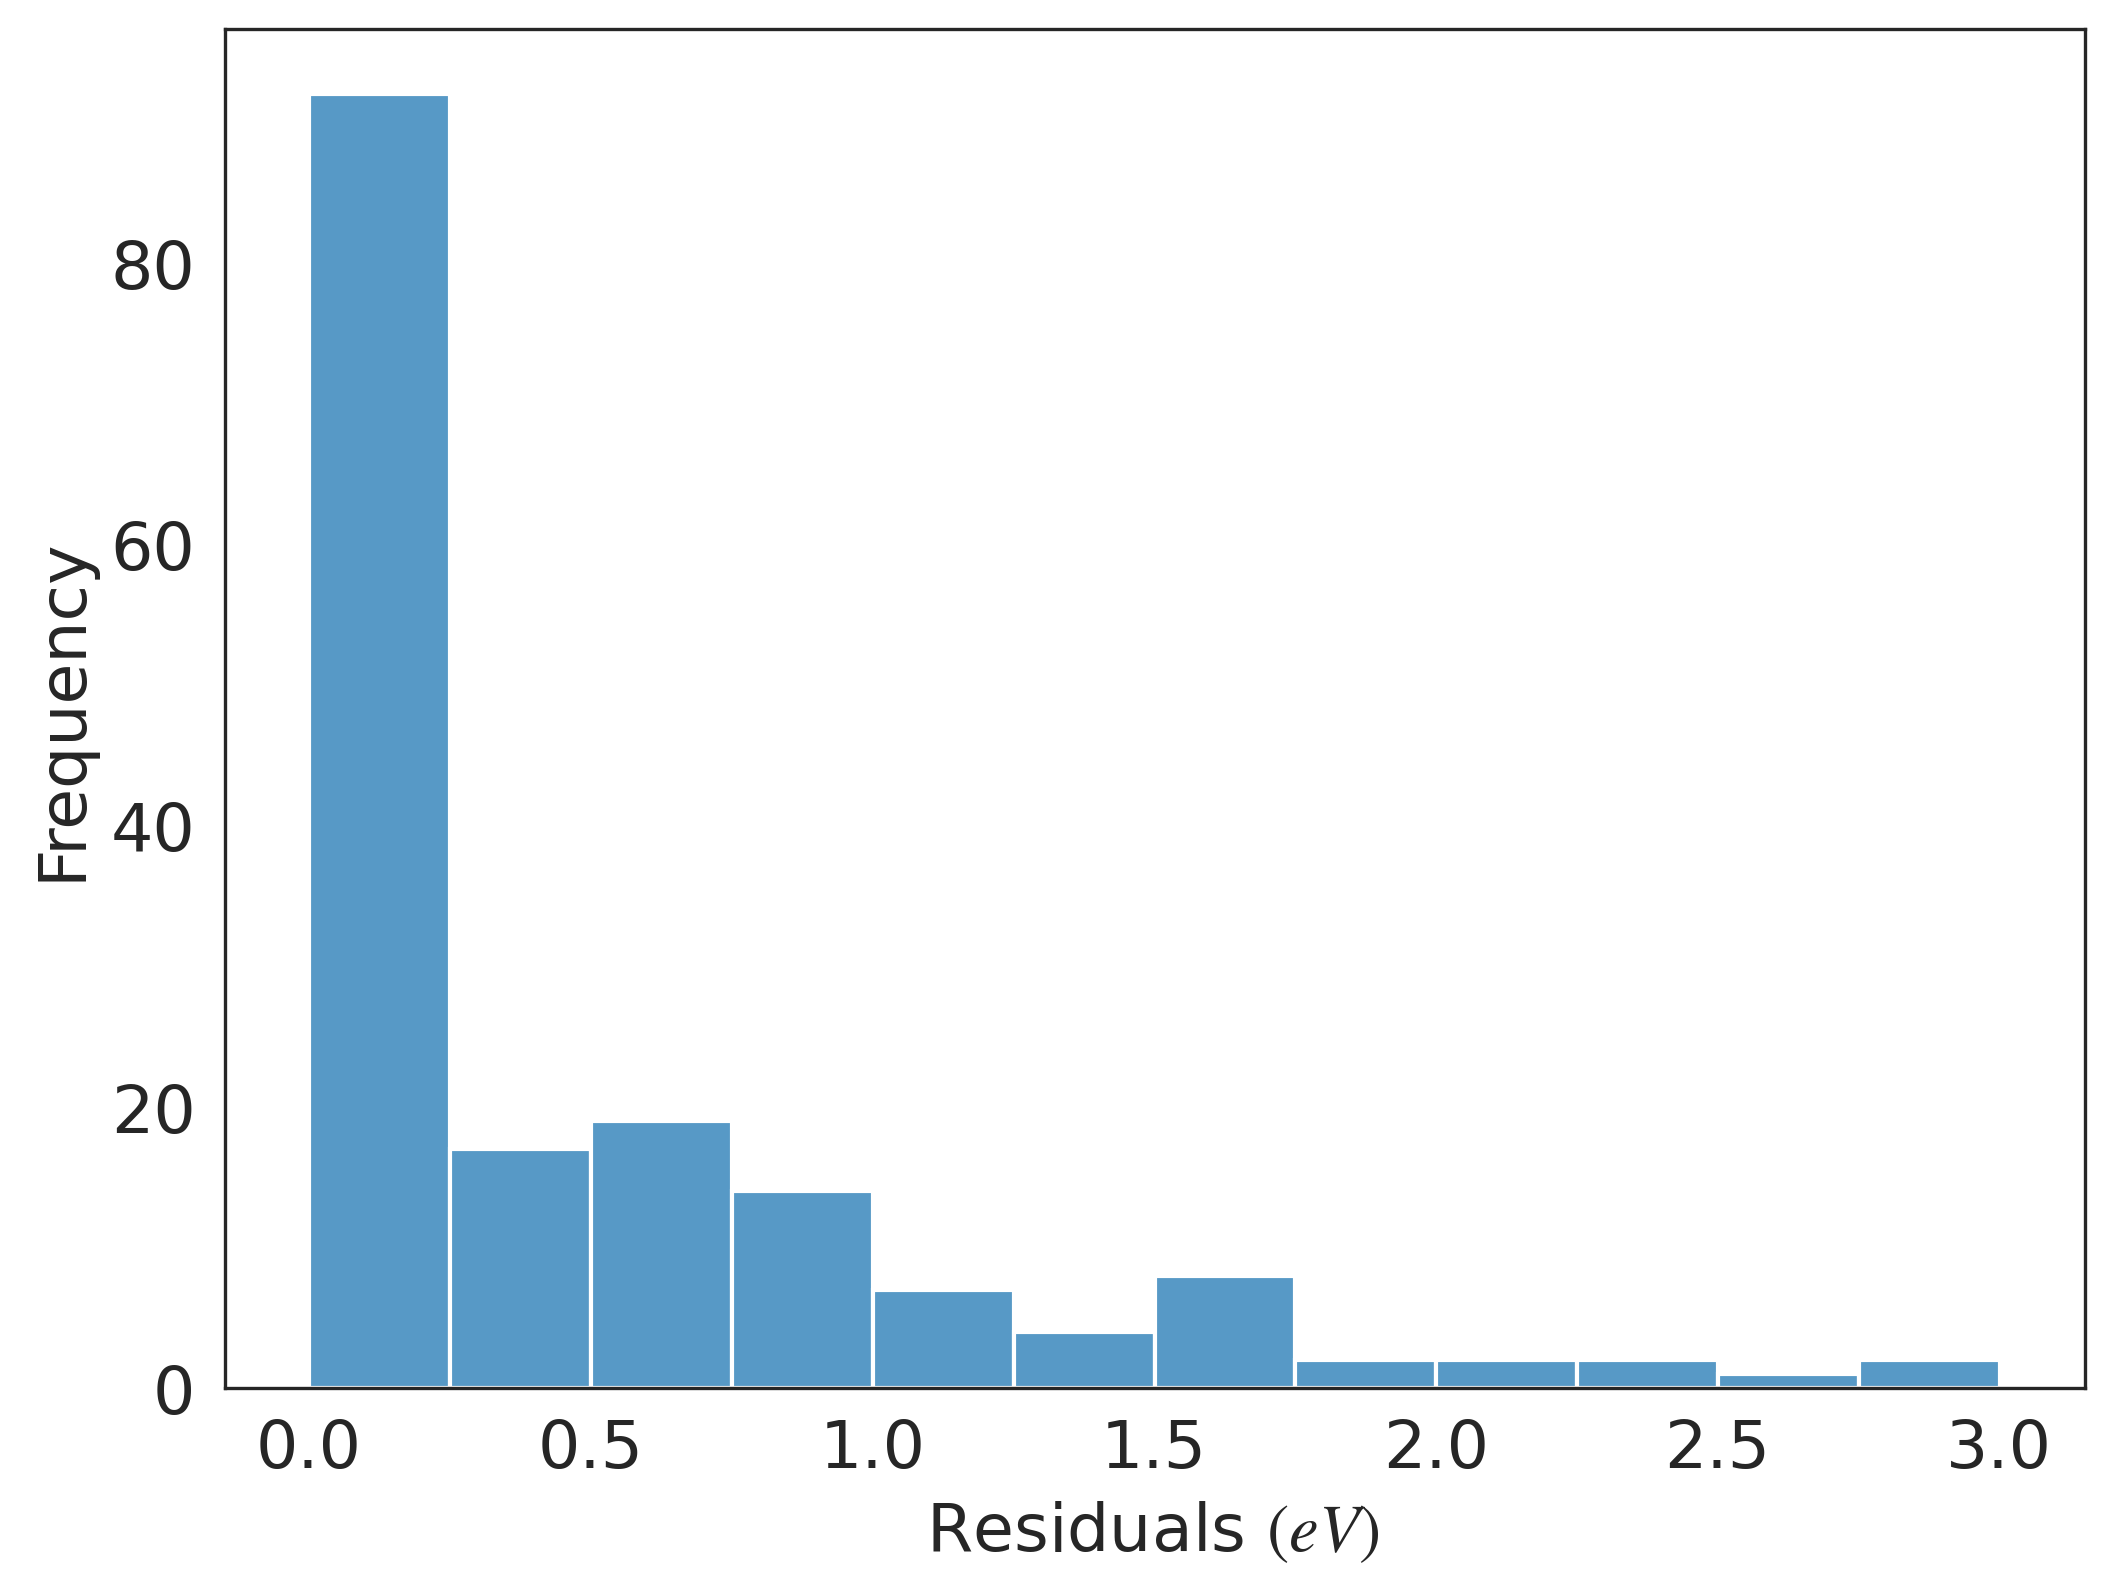

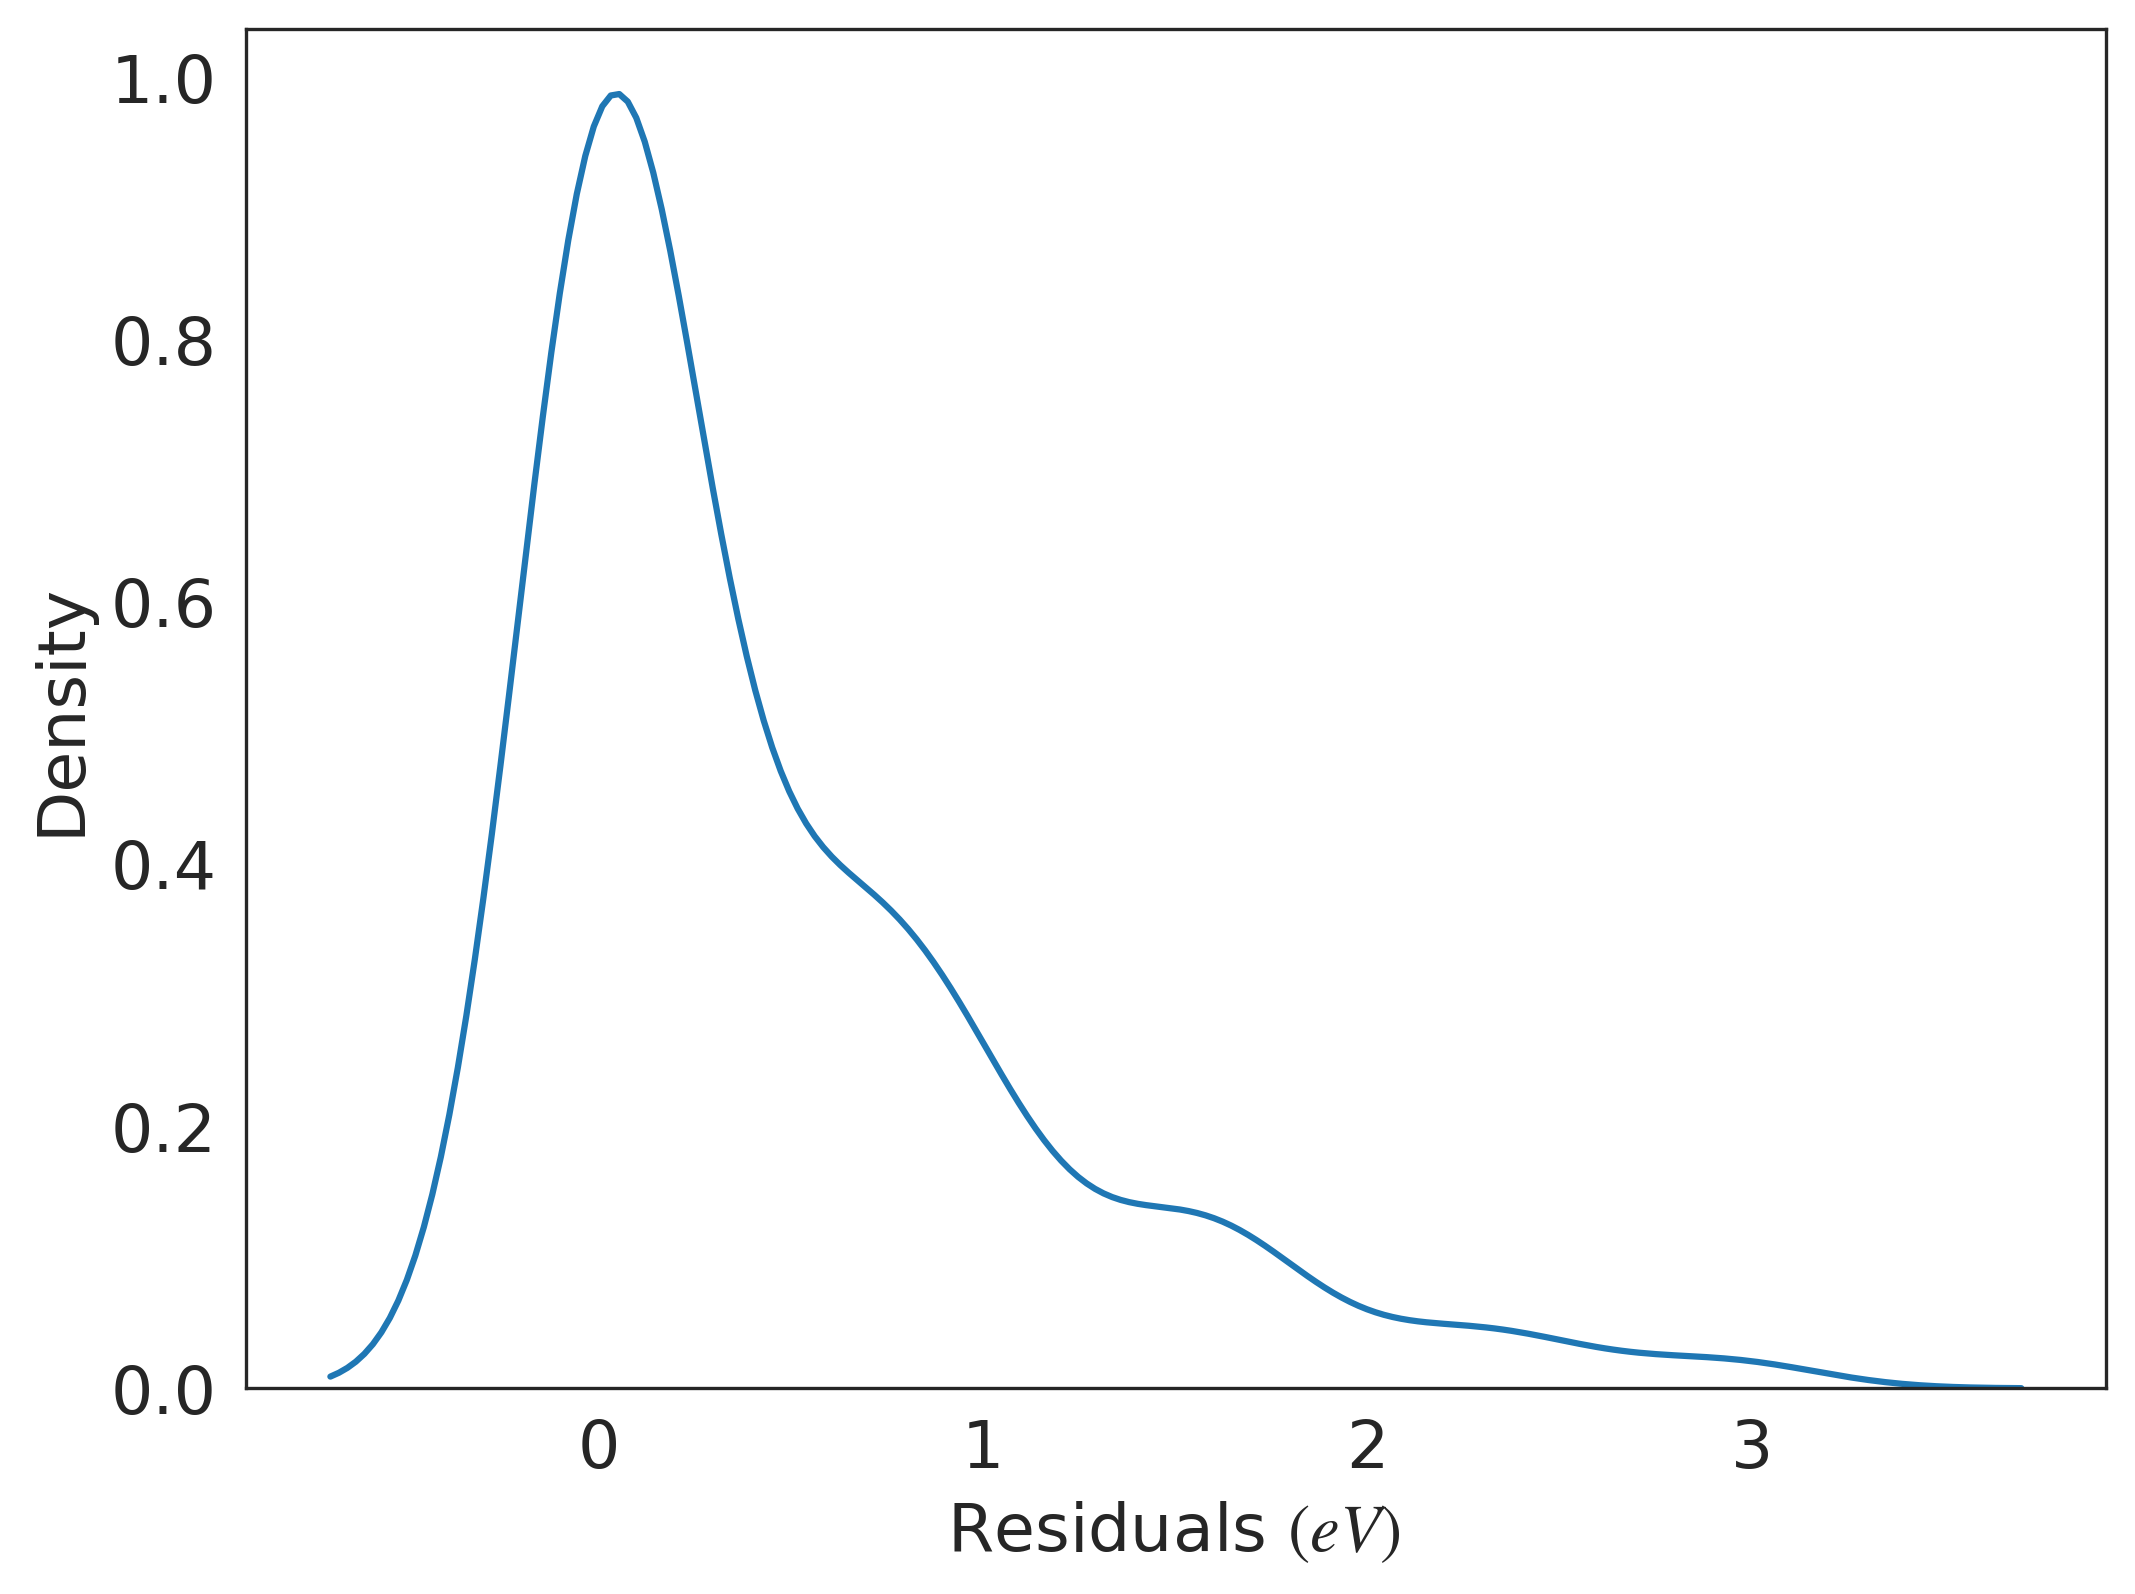

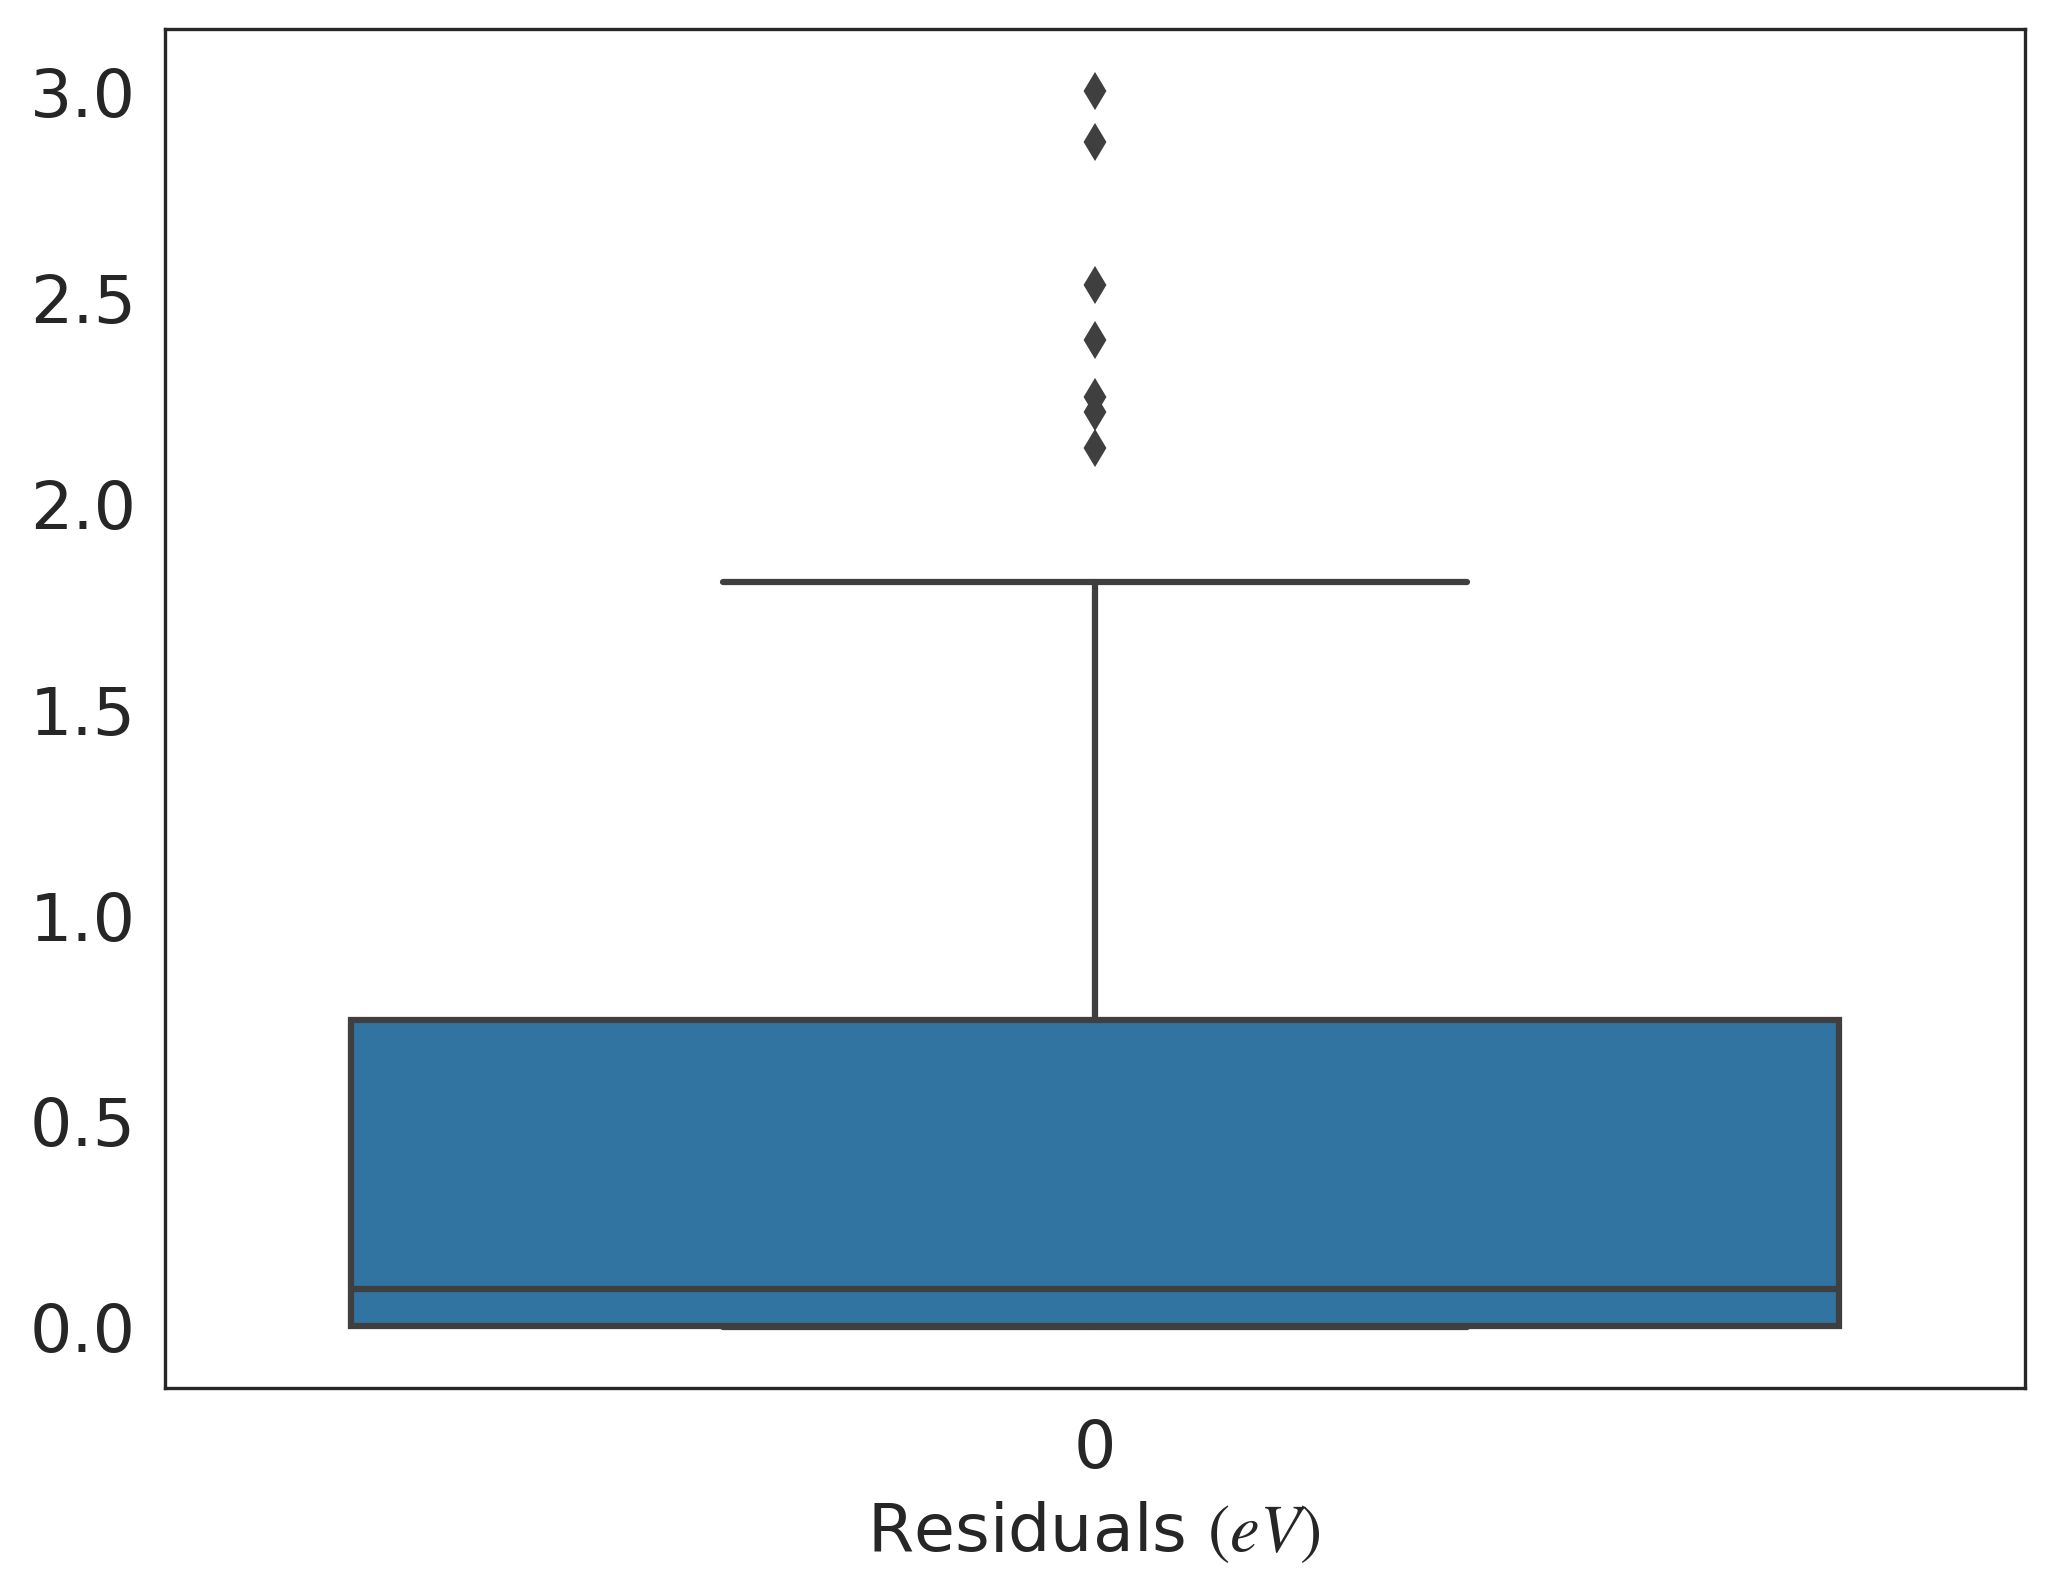

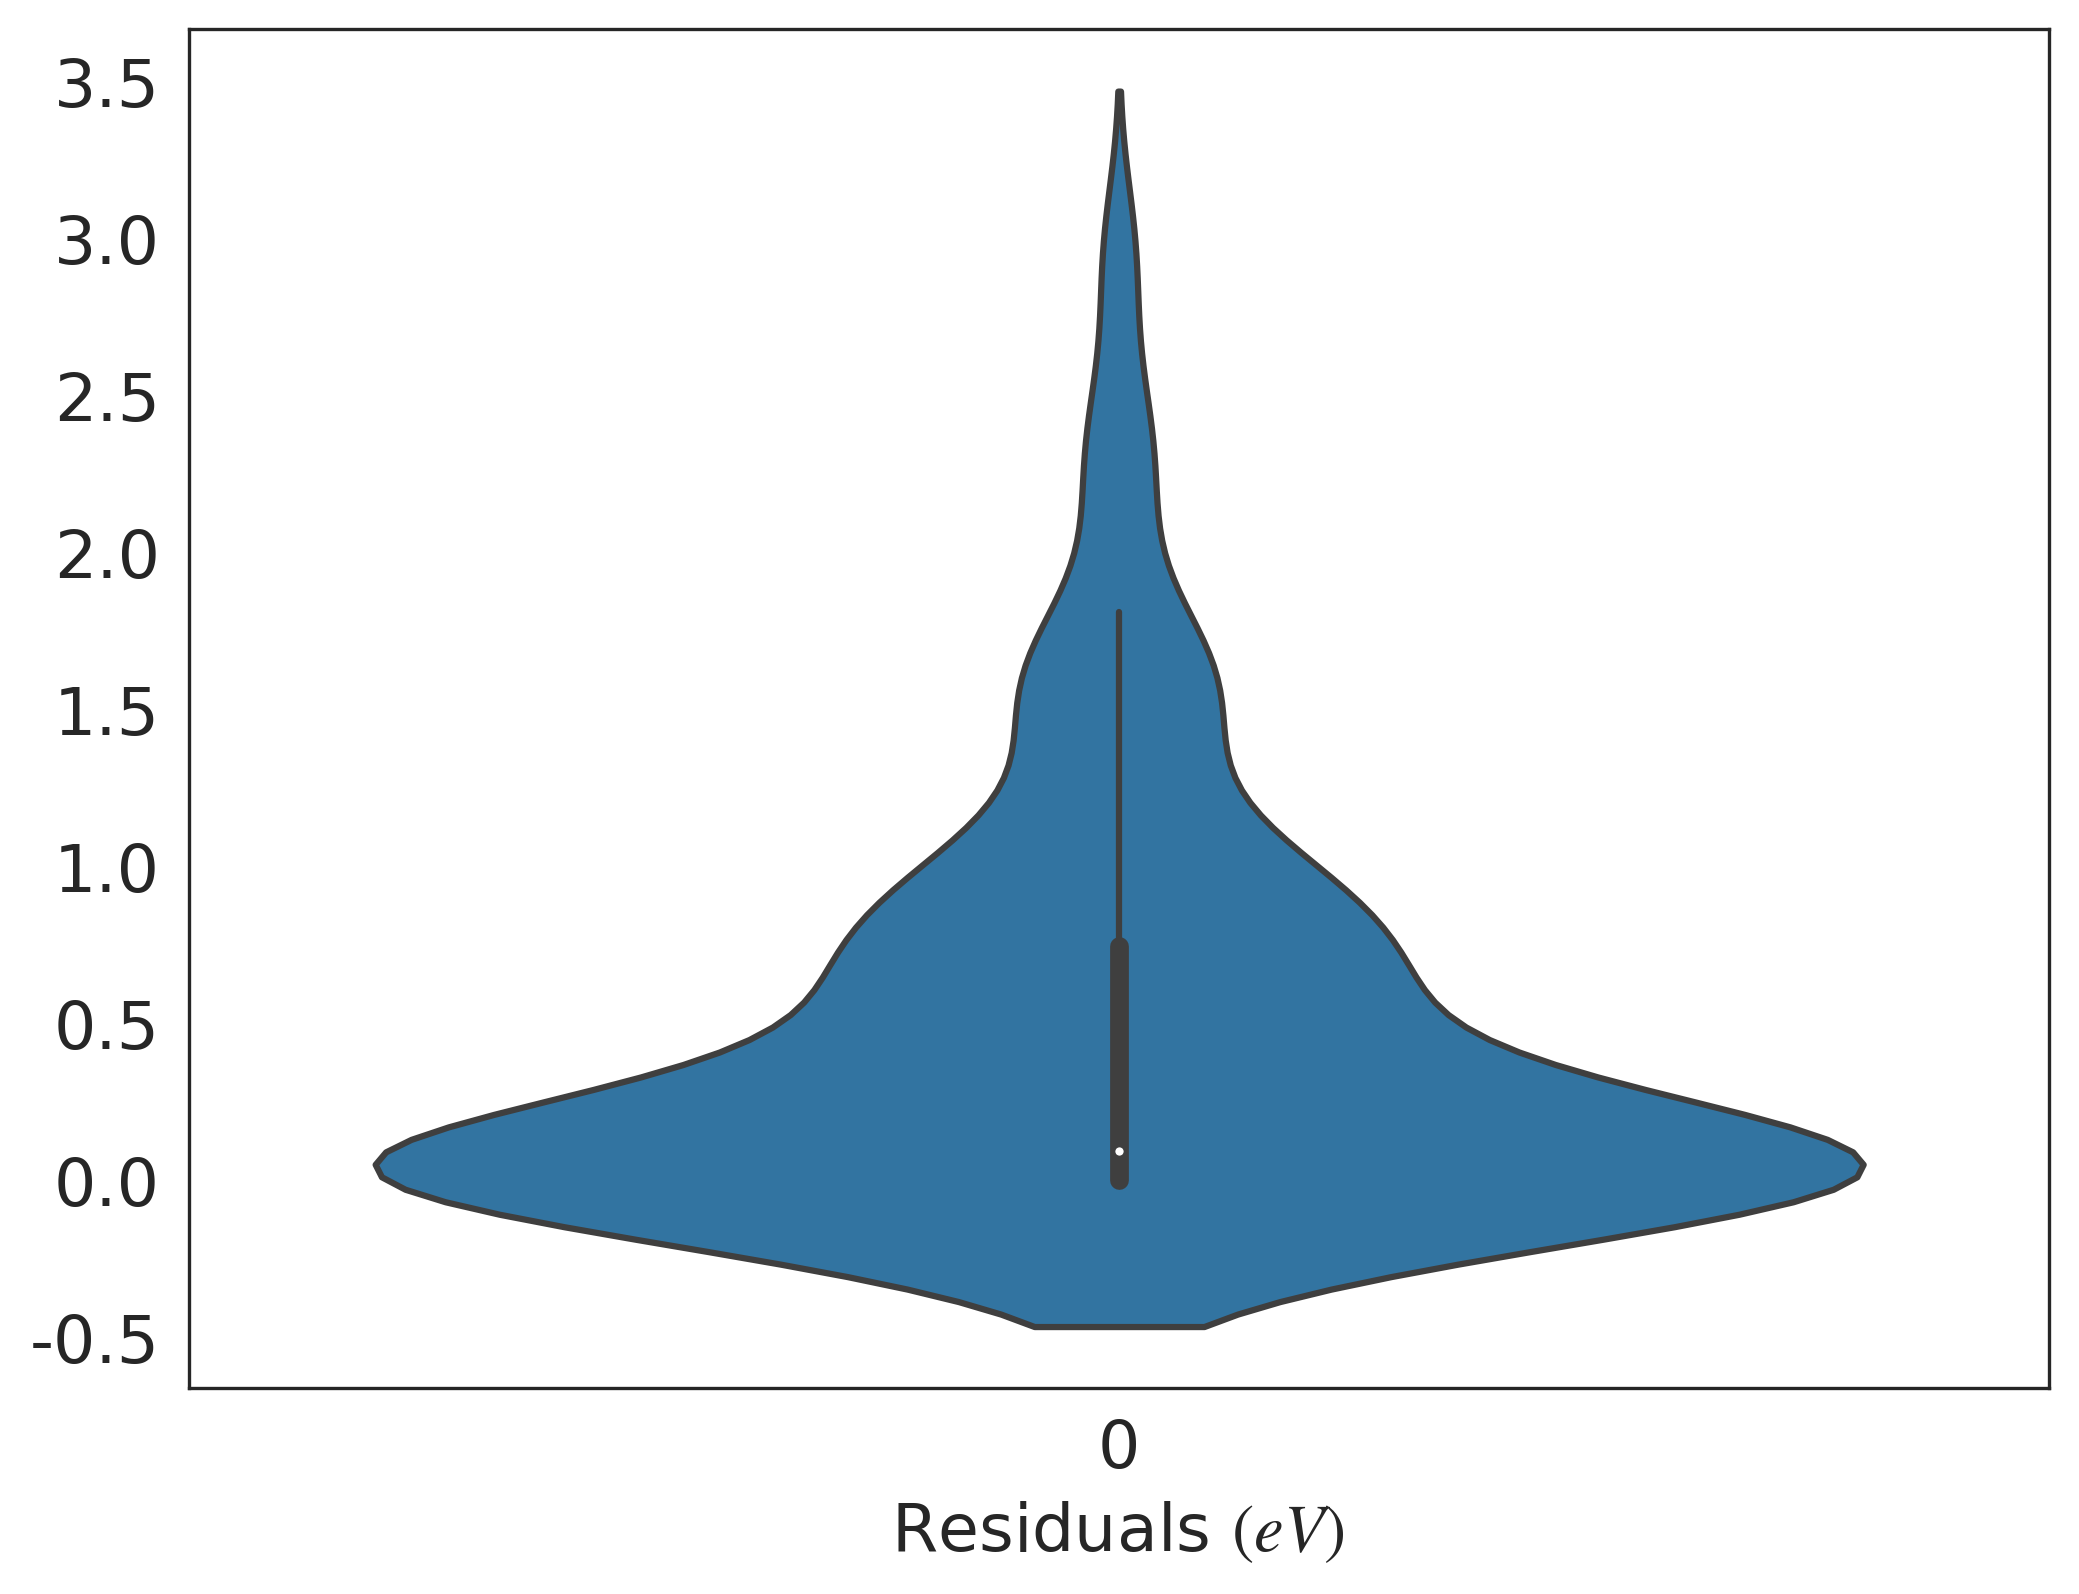

In [9]:
# Plot the distribution of real values and predicted values
plt.figure(figsize=(8, 6),facecolor='white')
sns.set_style('white')
model.load_network(f'./models/trained_models/fold_{best_fold}_spacegroup.pth')
real = spinels['target']
model.load_data(spinels)
pred  = model.predict(model.data_loader)[1]
error = np.abs(real - pred)
# Histogram
sns.histplot(error)
plt.xlabel('Residuals '+r'$(eV)$ ')
plt.ylabel('Frequency')
plt.show()

# Kernel Density Estimation
sns.kdeplot(error)
plt.xlabel('Residuals '+r'$(eV)$ ')
plt.ylabel('Density')
plt.show()

# Boxplot
sns.boxplot(error)
plt.xlabel('Residuals '+r'$(eV)$ ')
plt.show()

# Violinplot
sns.violinplot(error)
plt.xlabel('Residuals '+r'$(eV)$ ')
plt.show()

In [10]:
pd.DataFrame(np.abs(error)).describe()

,target
count,170.000000
mean,0.466310
std,0.650761
min,0.000010
25%,0.000586
50%,0.092207
75%,0.745089
max,3.001669


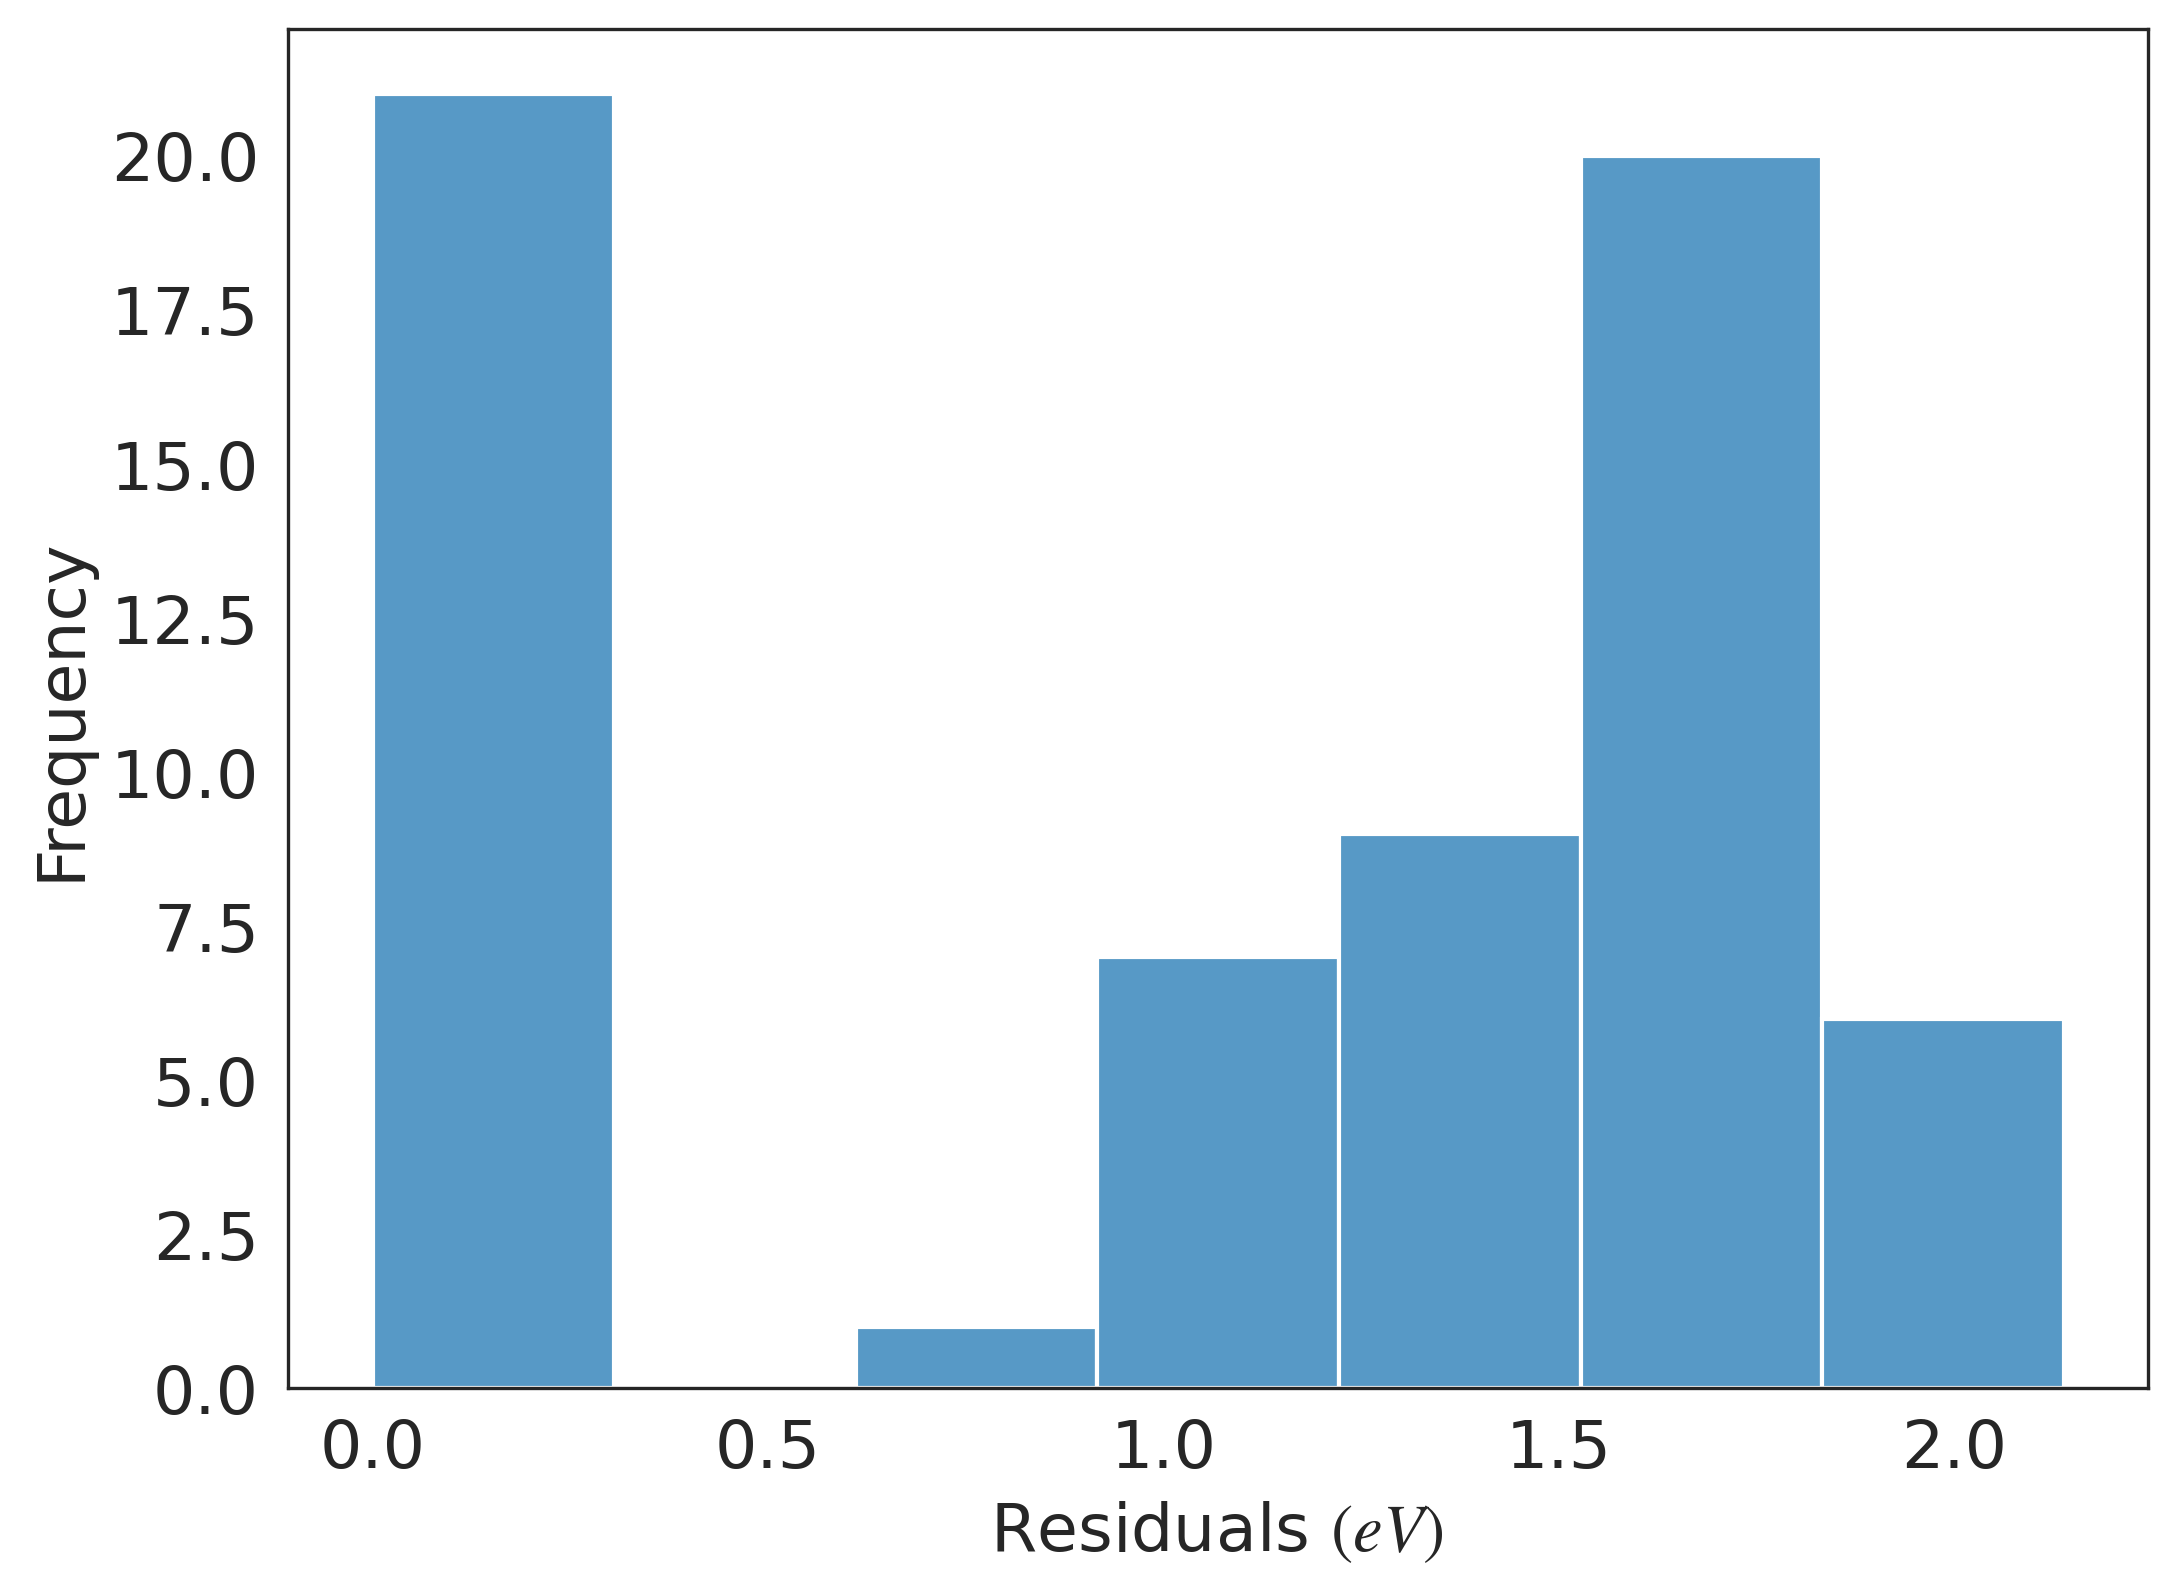

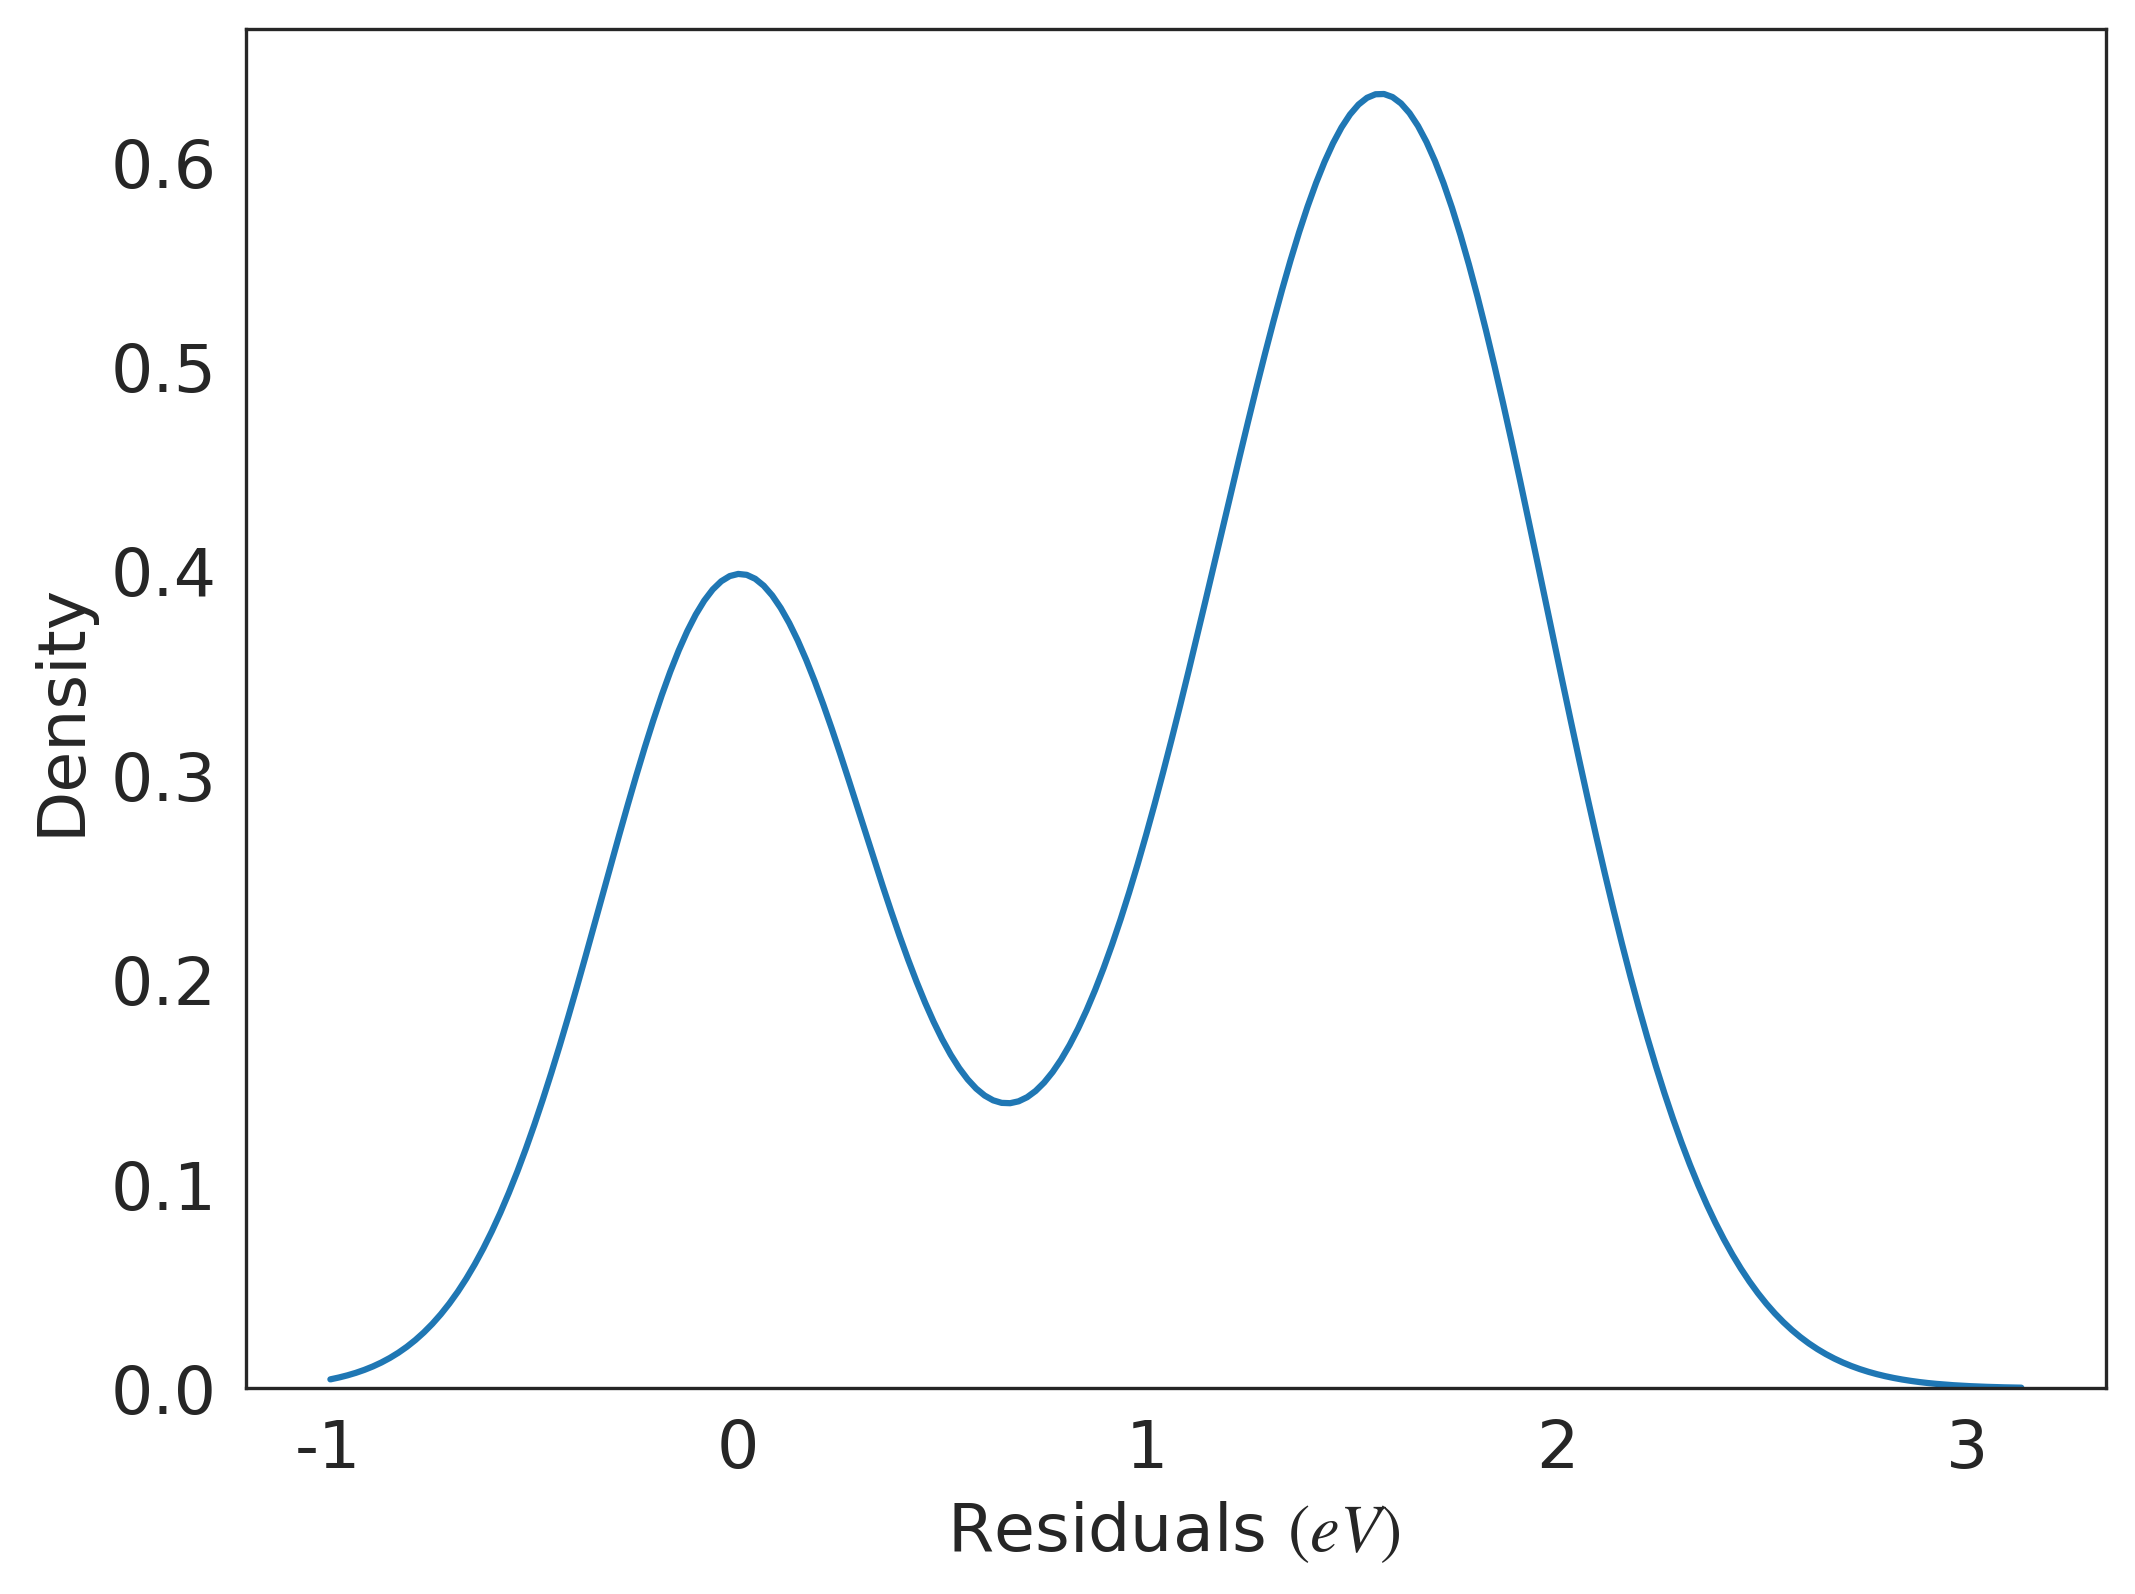

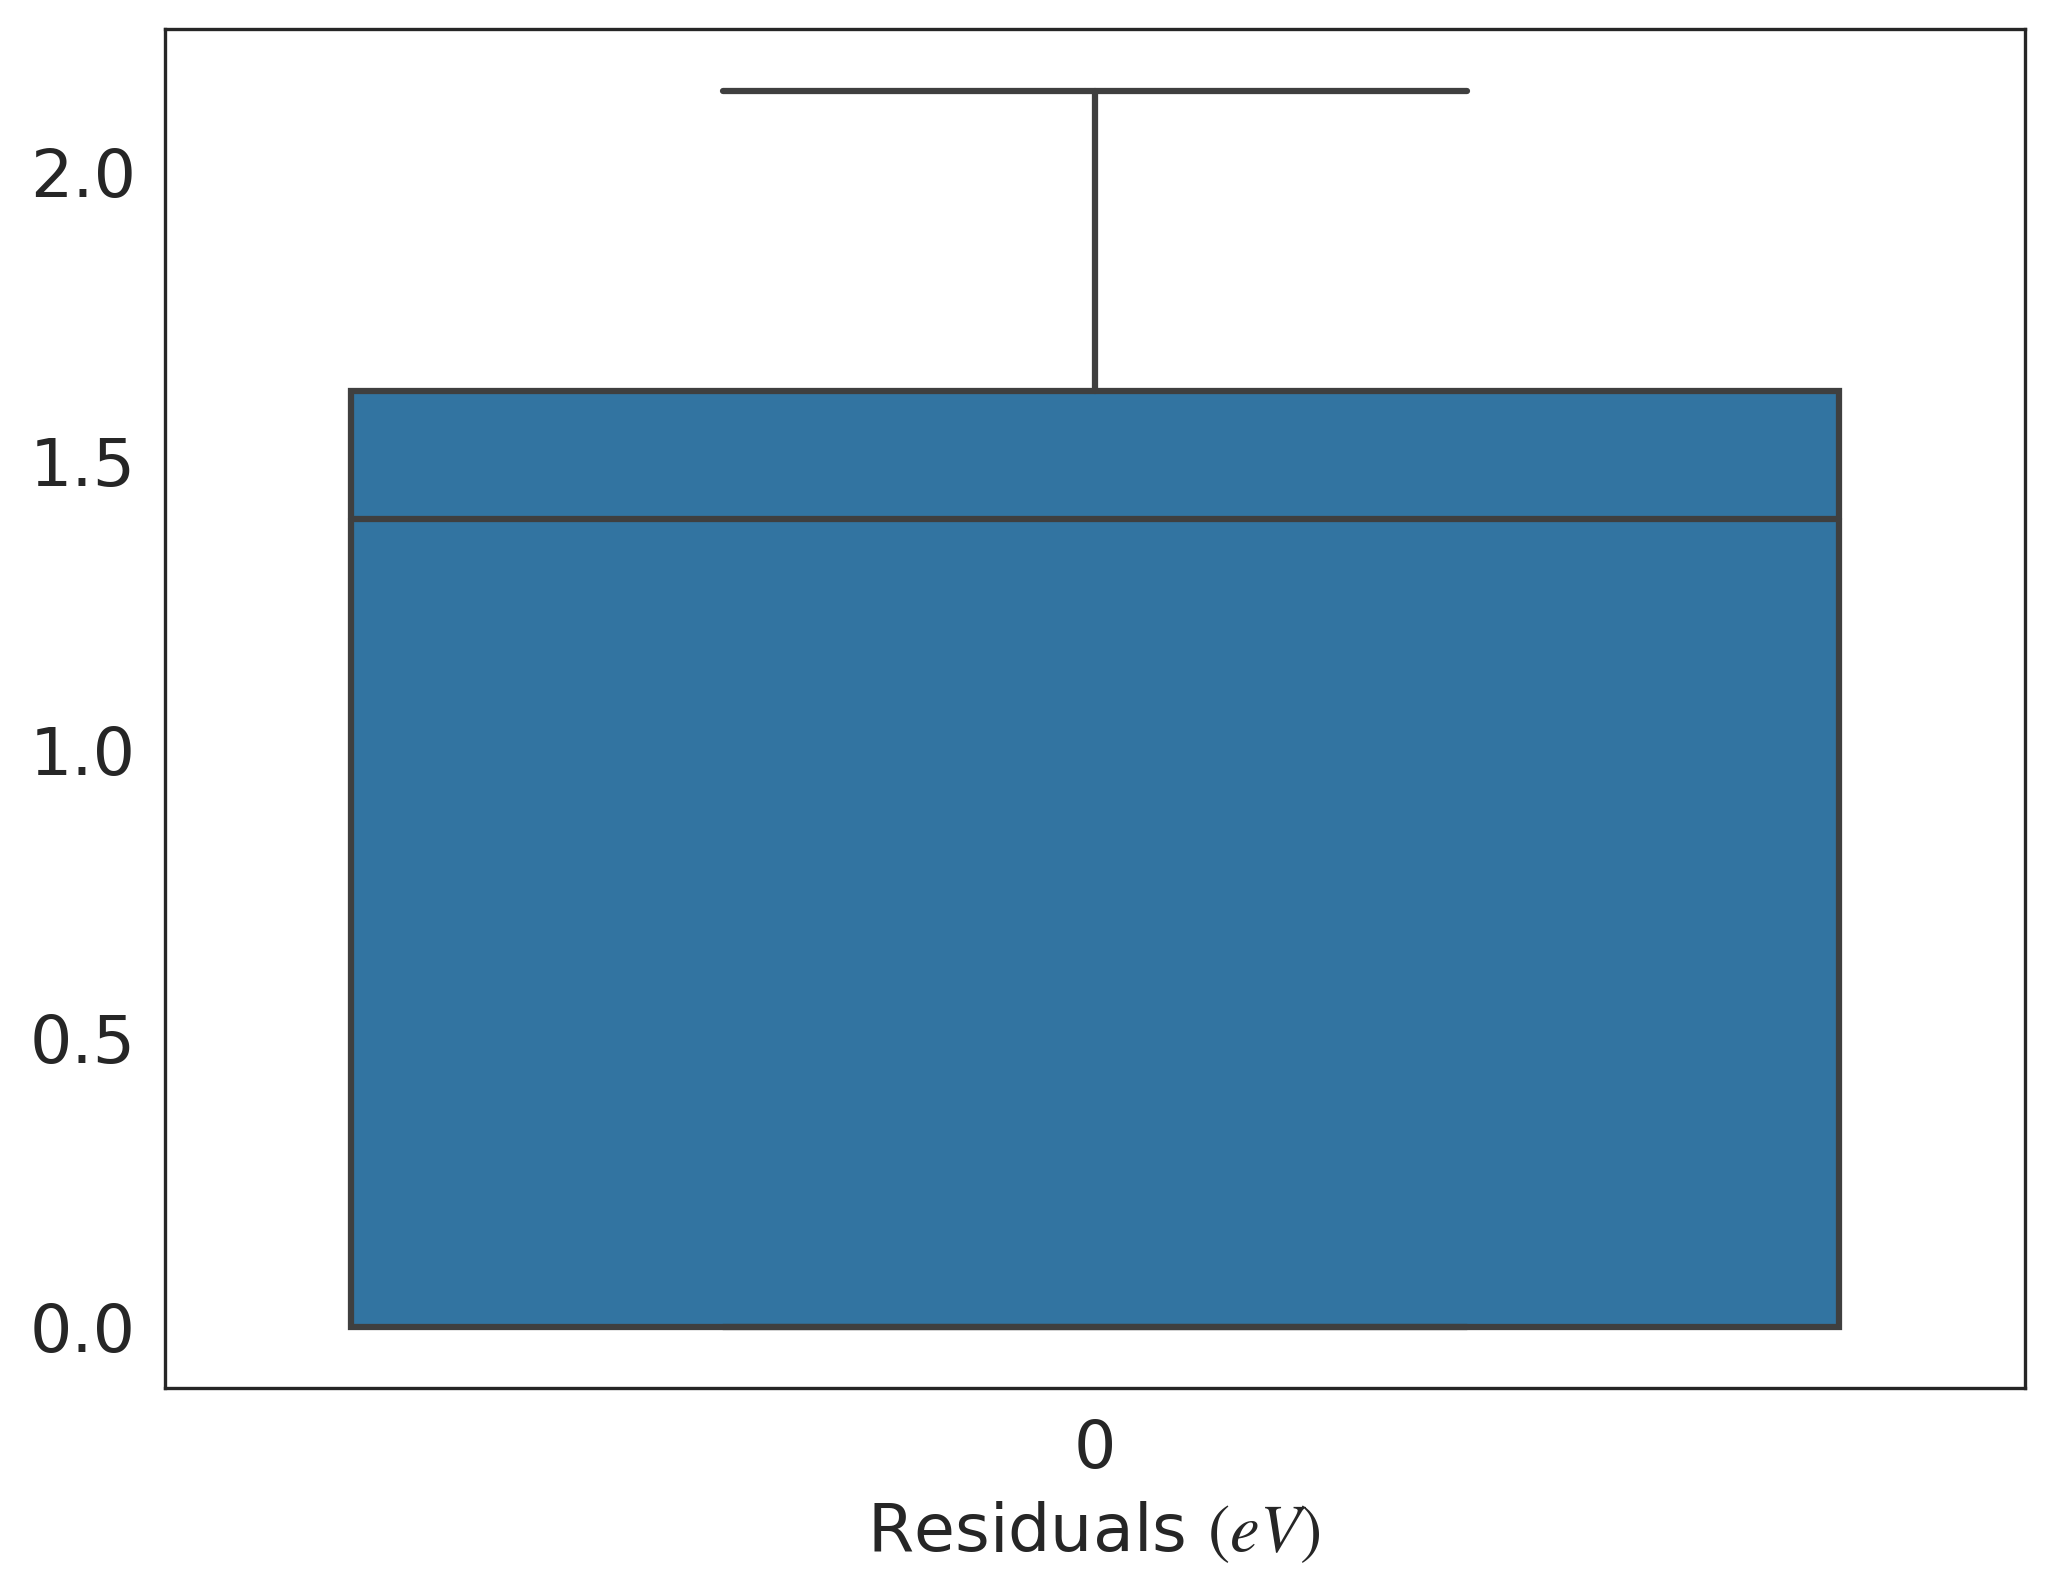

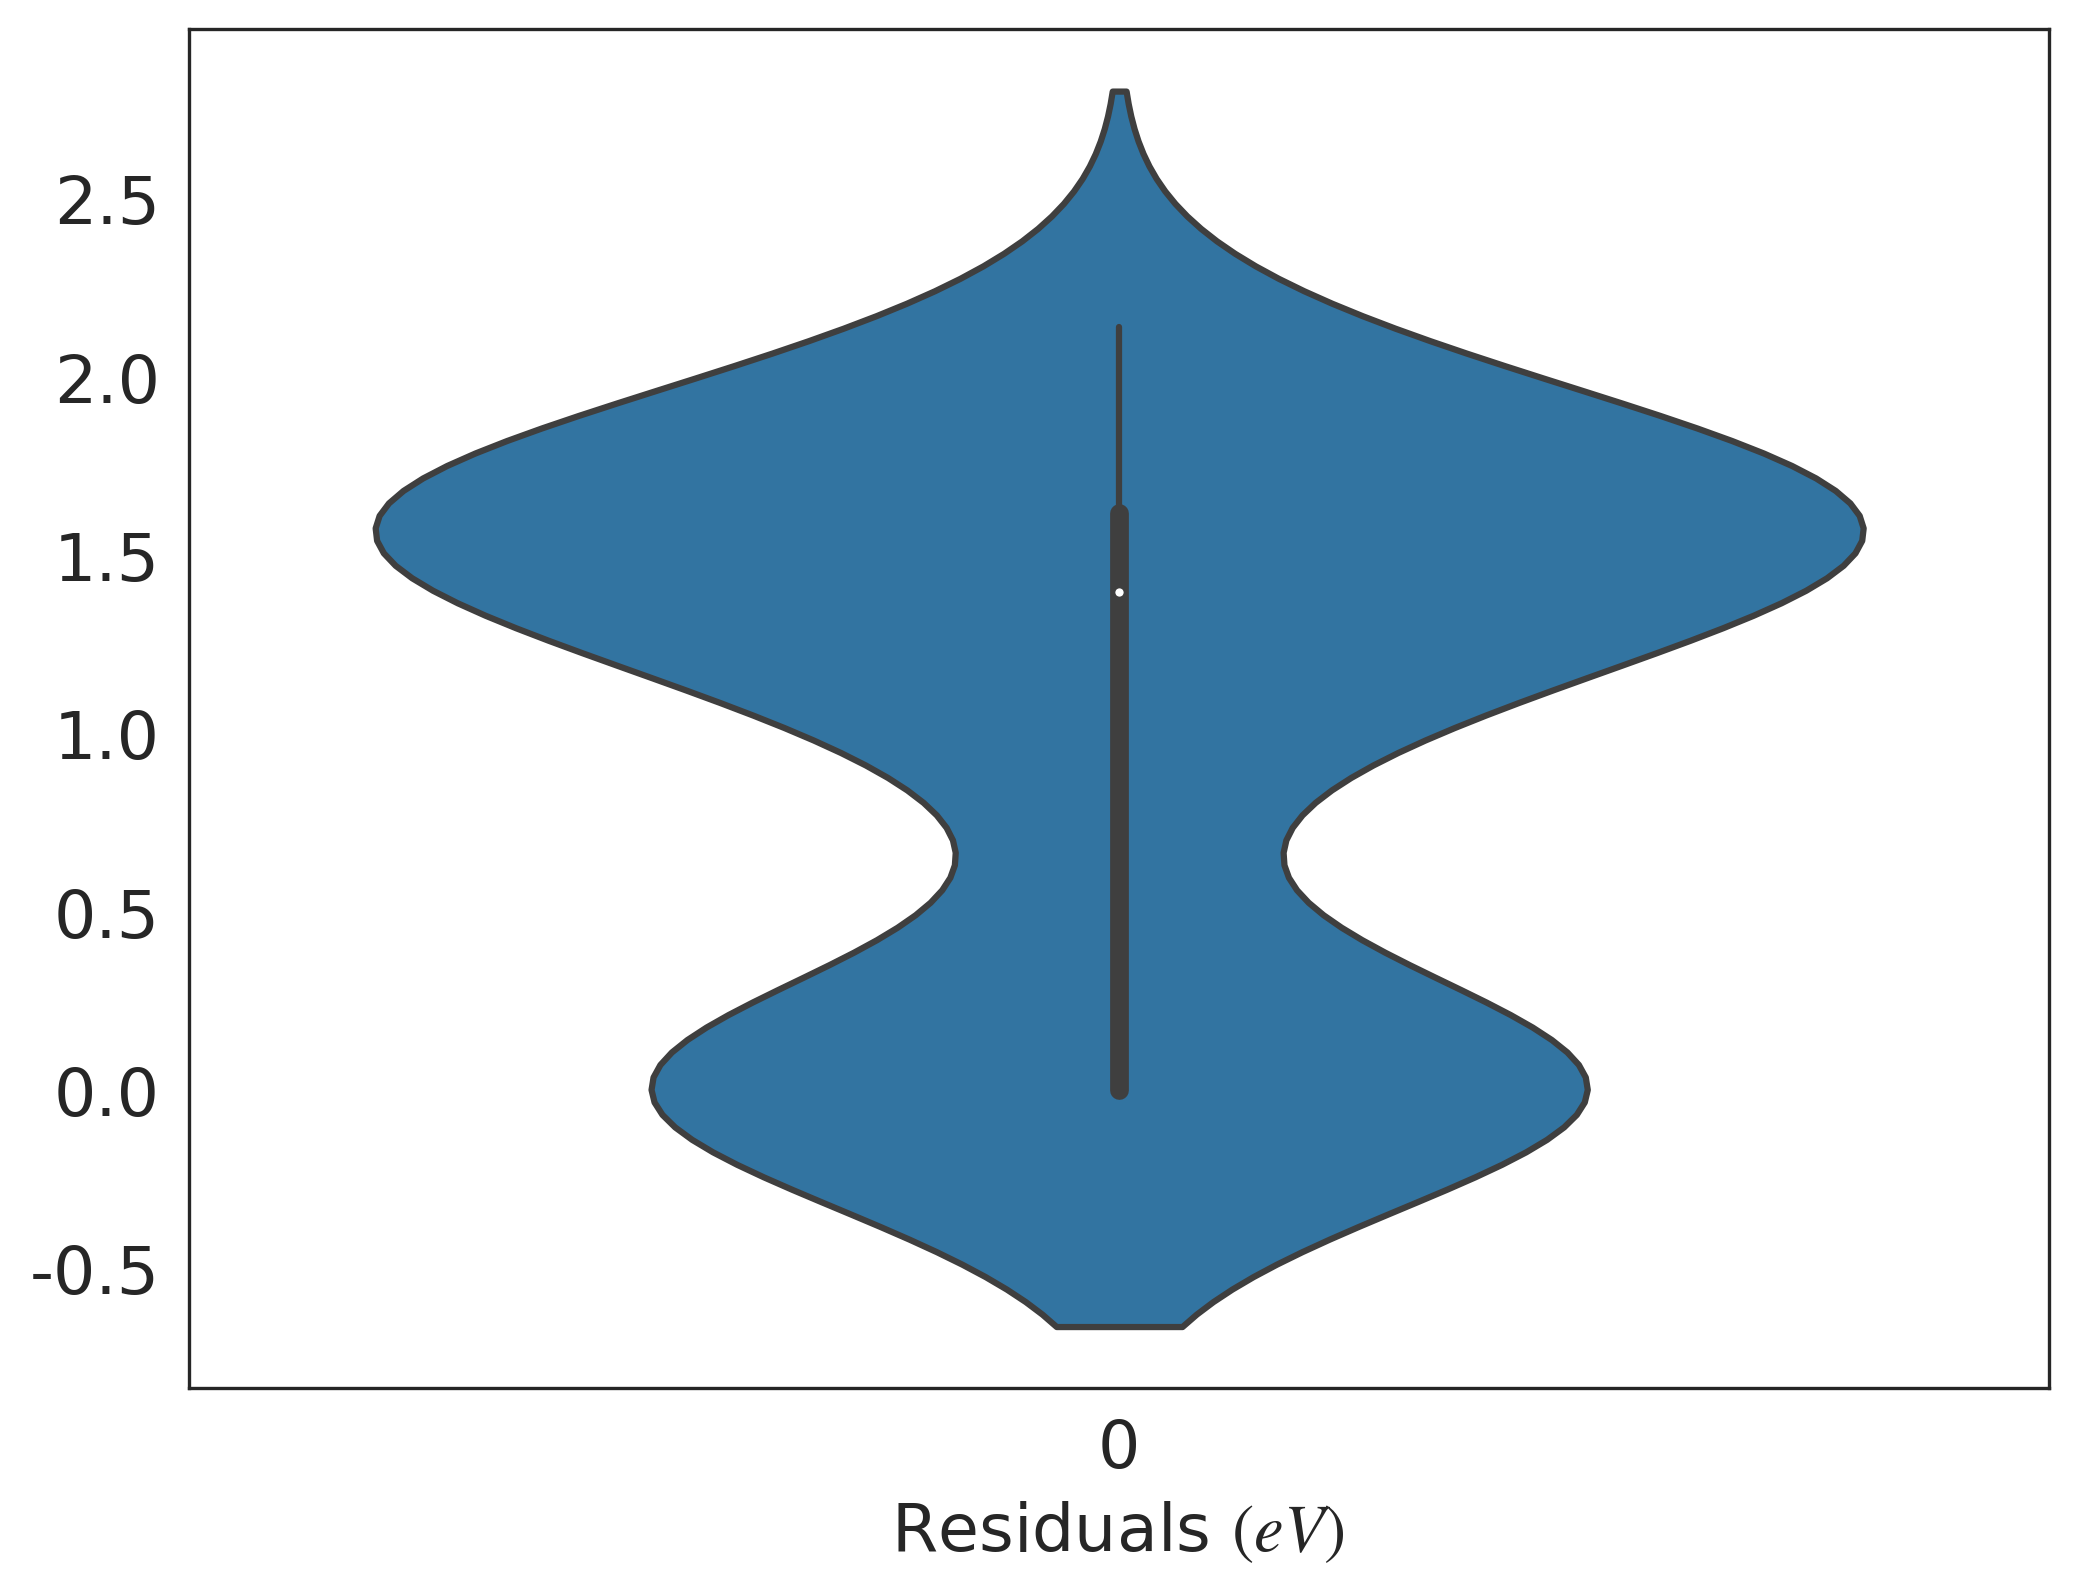

In [11]:
spinels_gga = spinels[spinels['GGA']!=spinels['target']]
real = spinels_gga['target']
gga = spinels_gga['GGA']
error = np.abs(real - gga).values
# Histogram
sns.histplot(error)
plt.xlabel('Residuals '+r'$(eV)$ ')
plt.ylabel('Frequency')
plt.show()

# Kernel Density Estimation
sns.kdeplot(error)
plt.xlabel('Residuals '+r'$(eV)$ ')
plt.ylabel('Density')
plt.show()

# Boxplot
sns.boxplot(error)
plt.xlabel('Residuals '+r'$(eV)$ ')
plt.show()

# Violinplot
sns.violinplot(error)
plt.xlabel('Residuals '+r'$(eV)$ ')
plt.show()

In [12]:
pd.DataFrame(np.abs(error)).describe()

,0
count,6.400000e+01
mean,1.028617e+00
std,7.607468e-01
min,1.040834e-16
25%,4.440892e-16
50%,1.397448e+00
75%,1.619306e+00
max,2.139132e+00


In [13]:
print(spinels_gga.shape)

(64, 6)


# Predicting new data band gaps

In [14]:
data = pd.read_csv('./data/cation_replacement_features.csv',index_col=0).reset_index(drop=True)
data['spacegroup'] = 227
data

,A_Density,B_Density,A_dipole Polarizability,B_dipole Polarizability,A_covalent Radius,B_covalent Radius,A_atomic Radius,B_atomic Radius,A_FirstIonization,B_FirstIonization,A_number of Valence Electrons,B_number of Valence Electrons,A_number,B_number,A_Period,B_Period,A_Electronegativity,B_Electronegativity,A_number of s+p Electrons,B_number of s+p Electrons,A_number of d Electrons,B_number of d Electrons,A_Mulliken EN,B_Mulliken EN,A-B_Density,(A+B)-O_Density,A-B_dipole Polarizability,(A+B)-O_dipole Polarizability,A-B_covalent Radius,(A+B)-O_covalent Radius,A-B_atomic Radius,(A+B)-O_atomic Radius,A-B_FirstIonization,(A+B)-O_FirstIonization,A-B_number of Valence Electrons,(A+B)-O_number of Valence Electrons,A-B_number,(A+B)-O_number,A-B_Period,(A+B)-O_Period,A-B_Electronegativity,(A+B)-O_Electronegativity,A-B_number of s+p Electrons,(A+B)-O_number of s+p Electrons,A-B_number of d Electrons,(A+B)-O_number of d Electrons,A-B_Mulliken EN,(A+B)-O_Mulliken EN,formula,spacegroup
0,0.971,14.88,162.7,136.00,155.0,238.0,1.80,2.8,495.8,1434.6,1.0,14.0,11.0,50.0,3.0,8.0,0.93,3.10,1.0,4.0,0.0,10.0,2.85,7.44,13.909,15.84957,26.70,293.40,83.0,330.0,1.00,4.00,938.8,616.5,13.0,9.0,39.0,53.0,5.0,9.0,2.17,0.59,3.0,1.0,10.0,10.0,4.59,2.75,NaMn2O4,227
1,8.690,24.80,46.0,132.00,136.0,250.0,1.55,2.7,867.8,1439.4,12.0,18.0,48.0,90.0,5.0,10.0,1.69,4.56,2.0,2.0,10.0,16.0,4.33,8.60,16.110,33.48857,86.00,172.70,114.0,323.0,1.15,3.65,571.6,993.3,6.0,24.0,42.0,130.0,5.0,13.0,2.87,2.81,0.0,2.0,6.0,26.0,4.27,5.39,Cd(RhO2)2,227
2,1.540,14.62,160.8,130.00,171.0,284.0,1.80,3.1,589.8,1116.6,2.0,6.0,20.0,98.0,4.0,10.0,1.00,3.56,2.0,6.0,0.0,20.0,2.20,6.20,13.080,16.15857,30.80,285.50,113.0,392.0,1.30,4.30,526.8,392.5,4.0,2.0,78.0,110.0,6.0,12.0,2.56,1.12,4.0,2.0,20.0,20.0,4.00,0.86,CaIn2O4,227
3,2.330,17.82,37.3,98.00,116.0,220.0,1.10,2.7,786.5,1474.2,4.0,20.0,14.0,56.0,3.0,8.0,1.90,3.82,4.0,4.0,0.0,16.0,4.77,8.80,15.490,20.14857,60.70,130.00,104.0,273.0,1.60,3.20,687.7,946.8,16.0,18.0,42.0,62.0,5.0,9.0,1.92,2.28,0.0,2.0,16.0,16.0,4.03,6.03,Si(NiO2)2,227
4,7.870,3.48,62.0,142.40,116.0,278.0,1.40,3.0,762.5,1475.4,8.0,4.0,26.0,24.0,4.0,6.0,1.83,2.62,2.0,4.0,6.0,0.0,4.06,7.50,4.390,11.34857,80.40,199.10,162.0,331.0,1.60,3.80,712.9,924.0,4.0,6.0,2.0,42.0,2.0,8.0,0.79,1.01,2.0,0.0,6.0,6.0,3.44,4.02,Mg2FeO4,227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111133,6.110,17.60,87.0,312.00,134.0,332.0,1.35,3.5,650.9,1162.0,5.0,6.0,23.0,134.0,4.0,12.0,1.63,2.46,2.0,4.0,3.0,0.0,3.60,6.20,11.490,23.70857,225.00,393.70,198.0,403.0,2.15,4.25,511.1,499.0,1.0,5.0,111.0,149.0,8.0,14.0,0.83,0.65,2.0,4.0,3.0,3.0,2.60,2.26,Ho2VO4,227
111134,6.110,24.00,87.0,52.28,134.0,240.0,1.35,2.8,650.9,1608.8,5.0,20.0,23.0,92.0,4.0,10.0,1.63,4.40,2.0,0.0,3.0,20.0,3.60,8.90,17.890,30.10857,34.72,133.98,106.0,311.0,1.45,3.55,957.9,945.8,15.0,19.0,69.0,107.0,6.0,12.0,2.77,2.59,2.0,0.0,17.0,23.0,5.30,4.96,V(PdO2)2,227
111135,6.110,14.52,87.0,400.00,134.0,346.0,1.35,3.7,650.9,1080.0,5.0,6.0,23.0,122.0,4.0,12.0,1.63,2.26,2.0,4.0,3.0,0.0,3.60,6.20,8.410,20.62857,313.00,481.70,212.0,417.0,2.35,4.45,429.1,417.0,1.0,5.0,99.0,137.0,8.0,14.0,0.63,0.45,2.0,4.0,3.0,3.0,2.60,2.26,Pm2VO4,227
111136,6.110,3.06,87.0,639.60,134.0,420.0,1.35,4.7,650.9,806.0,5.0,2.0,23.0,74.0,4.0,10.0,1.63,1.64,2.0,2.0,3.0,0.0,3.60,4.68,3.050,9.16857,552.60,721.30,286.0,491.0,3.35,5.45,155.1,143.0,3.0,1.0,51.0,89.0,6.0,12.0,0.01,0.17,0.0,2.0,3.0,3.0,1.08,0.74,Rb2VO4,227


In [15]:
model = Model(CrabNet(compute_device=compute_device).to(compute_device),
                      verbose=True, classification=False)
model.load_network('./models/trained_models/fold_1_spacegroup.pth')
data['target'] = 0
model.load_data(data)
result= model.predict(model.data_loader)
result


Model architecture: out_dims, d_model, N, heads
3, 512, 2, 4
Running on compute device: cpu
Model size: 11992839 parameters



Generating EDM: 100%|██████████| 111138/111138 [00:01<00:00, 92050.73formulae/s] 


loading data with up to 4 elements in the formula


(array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 7.97629356e-04,  2.00943208e+00,  3.35361576e+00, ...,
         9.07897949e-04,  3.07108498e+00, -7.26580620e-04]),
 array(['NaMn2O4', 'Cd(RhO2)2', 'CaIn2O4', ..., 'Pm2VO4', 'Rb2VO4',
        'Yb2VO4'], dtype=object),
 array([0.00636797, 0.61433405, 0.07340897, ..., 0.00519793, 0.07736728,
        0.00587722]))

In [16]:
res_df = pd.DataFrame({"composition": result[2], "real": result[0], "pred": result[1]})
res_df['pred']

0         0.000798
1         2.009432
2         3.353616
3         1.047331
4        -0.000105
            ...   
111133    0.000522
111134    0.001292
111135    0.000908
111136    3.071085
111137   -0.000727
Name: pred, Length: 111138, dtype: float64

In [17]:
data['band gap'] = res_df['pred'].map(lambda x : 0 if x<0.01 else x)
data['band gap']

0         0.000000
1         2.009432
2         3.353616
3         1.047331
4         0.000000
            ...   
111133    0.000000
111134    0.000000
111135    0.000000
111136    3.071085
111137    0.000000
Name: band gap, Length: 111138, dtype: float64

In [18]:
data = data.drop(columns=['spacegroup','target'])
data

,A_Density,B_Density,A_dipole Polarizability,B_dipole Polarizability,A_covalent Radius,B_covalent Radius,A_atomic Radius,B_atomic Radius,A_FirstIonization,B_FirstIonization,A_number of Valence Electrons,B_number of Valence Electrons,A_number,B_number,A_Period,B_Period,A_Electronegativity,B_Electronegativity,A_number of s+p Electrons,B_number of s+p Electrons,A_number of d Electrons,B_number of d Electrons,A_Mulliken EN,B_Mulliken EN,A-B_Density,(A+B)-O_Density,A-B_dipole Polarizability,(A+B)-O_dipole Polarizability,A-B_covalent Radius,(A+B)-O_covalent Radius,A-B_atomic Radius,(A+B)-O_atomic Radius,A-B_FirstIonization,(A+B)-O_FirstIonization,A-B_number of Valence Electrons,(A+B)-O_number of Valence Electrons,A-B_number,(A+B)-O_number,A-B_Period,(A+B)-O_Period,A-B_Electronegativity,(A+B)-O_Electronegativity,A-B_number of s+p Electrons,(A+B)-O_number of s+p Electrons,A-B_number of d Electrons,(A+B)-O_number of d Electrons,A-B_Mulliken EN,(A+B)-O_Mulliken EN,formula,count,band gap
0,0.971,14.88,162.7,136.00,155.0,238.0,1.80,2.8,495.8,1434.6,1.0,14.0,11.0,50.0,3.0,8.0,0.93,3.10,1.0,4.0,0.0,10.0,2.85,7.44,13.909,15.84957,26.70,293.40,83.0,330.0,1.00,4.00,938.8,616.5,13.0,9.0,39.0,53.0,5.0,9.0,2.17,0.59,3.0,1.0,10.0,10.0,4.59,2.75,NaMn2O4,3,0.000000
1,8.690,24.80,46.0,132.00,136.0,250.0,1.55,2.7,867.8,1439.4,12.0,18.0,48.0,90.0,5.0,10.0,1.69,4.56,2.0,2.0,10.0,16.0,4.33,8.60,16.110,33.48857,86.00,172.70,114.0,323.0,1.15,3.65,571.6,993.3,6.0,24.0,42.0,130.0,5.0,13.0,2.87,2.81,0.0,2.0,6.0,26.0,4.27,5.39,Cd(RhO2)2,3,2.009432
2,1.540,14.62,160.8,130.00,171.0,284.0,1.80,3.1,589.8,1116.6,2.0,6.0,20.0,98.0,4.0,10.0,1.00,3.56,2.0,6.0,0.0,20.0,2.20,6.20,13.080,16.15857,30.80,285.50,113.0,392.0,1.30,4.30,526.8,392.5,4.0,2.0,78.0,110.0,6.0,12.0,2.56,1.12,4.0,2.0,20.0,20.0,4.00,0.86,CaIn2O4,3,3.353616
3,2.330,17.82,37.3,98.00,116.0,220.0,1.10,2.7,786.5,1474.2,4.0,20.0,14.0,56.0,3.0,8.0,1.90,3.82,4.0,4.0,0.0,16.0,4.77,8.80,15.490,20.14857,60.70,130.00,104.0,273.0,1.60,3.20,687.7,946.8,16.0,18.0,42.0,62.0,5.0,9.0,1.92,2.28,0.0,2.0,16.0,16.0,4.03,6.03,Si(NiO2)2,3,1.047331
4,7.870,3.48,62.0,142.40,116.0,278.0,1.40,3.0,762.5,1475.4,8.0,4.0,26.0,24.0,4.0,6.0,1.83,2.62,2.0,4.0,6.0,0.0,4.06,7.50,4.390,11.34857,80.40,199.10,162.0,331.0,1.60,3.80,712.9,924.0,4.0,6.0,2.0,42.0,2.0,8.0,0.79,1.01,2.0,0.0,6.0,6.0,3.44,4.02,Mg2FeO4,3,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111133,6.110,17.60,87.0,312.00,134.0,332.0,1.35,3.5,650.9,1162.0,5.0,6.0,23.0,134.0,4.0,12.0,1.63,2.46,2.0,4.0,3.0,0.0,3.60,6.20,11.490,23.70857,225.00,393.70,198.0,403.0,2.15,4.25,511.1,499.0,1.0,5.0,111.0,149.0,8.0,14.0,0.83,0.65,2.0,4.0,3.0,3.0,2.60,2.26,Ho2VO4,3,0.000000
111134,6.110,24.00,87.0,52.28,134.0,240.0,1.35,2.8,650.9,1608.8,5.0,20.0,23.0,92.0,4.0,10.0,1.63,4.40,2.0,0.0,3.0,20.0,3.60,8.90,17.890,30.10857,34.72,133.98,106.0,311.0,1.45,3.55,957.9,945.8,15.0,19.0,69.0,107.0,6.0,12.0,2.77,2.59,2.0,0.0,17.0,23.0,5.30,4.96,V(PdO2)2,3,0.000000
111135,6.110,14.52,87.0,400.00,134.0,346.0,1.35,3.7,650.9,1080.0,5.0,6.0,23.0,122.0,4.0,12.0,1.63,2.26,2.0,4.0,3.0,0.0,3.60,6.20,8.410,20.62857,313.00,481.70,212.0,417.0,2.35,4.45,429.1,417.0,1.0,5.0,99.0,137.0,8.0,14.0,0.63,0.45,2.0,4.0,3.0,3.0,2.60,2.26,Pm2VO4,3,0.000000
111136,6.110,3.06,87.0,639.60,134.0,420.0,1.35,4.7,650.9,806.0,5.0,2.0,23.0,74.0,4.0,10.0,1.63,1.64,2.0,2.0,3.0,0.0,3.60,4.68,3.050,9.16857,552.60,721.30,286.0,491.0,3.35,5.45,155.1,143.0,3.0,1.0,51.0,89.0,6.0,12.0,0.01,0.17,0.0,2.0,3.0,3.0,1.08,0.74,Rb2VO4,3,3.071085


In [19]:
# data.to_csv('./data/cation_replacement_features_pred.csv')

In [23]:
model.model.eval()

CrabNet(
  (encoder): Encoder(
    (embed): Embedder(
      (fc_mat2vec): Linear(in_features=200, out_features=512, bias=True)
      (cbfv): Embedding(119, 200)
    )
    (pe): FractionalEncoder()
    (ple): FractionalEncoder()
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=1024, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=1024, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
        (1): TransformerEncoderLayer(
   